In [3]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/closed_loop.py



In [4]:
%%capture output
!unzip Model.zip

In [5]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from closed_loop import closed_loop


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start Simulation :
EES frequency : 0. Hz
Number Ia fibers recruited by EES: 60 / 60
Number II fibers recruited by EES : 60 / 60
Number Efferent fibers recruited by EES : 0 / 169
--- Iteration 1 of 2 ---
Number of flexor recruited motoneuron: 0/169
Number of extensor recruited motoneuron: 0/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 2 of 2 ---
Number of flexor recruited motoneuron: 0/169
Number of extensor recruited motoneuron: 0/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

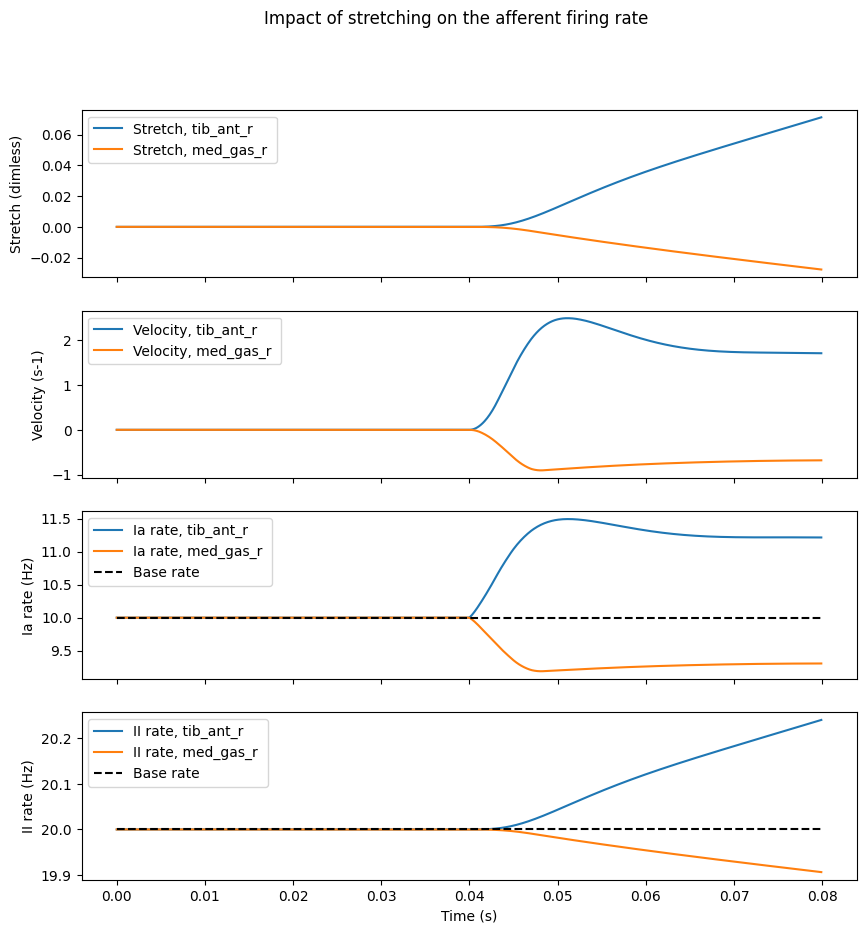

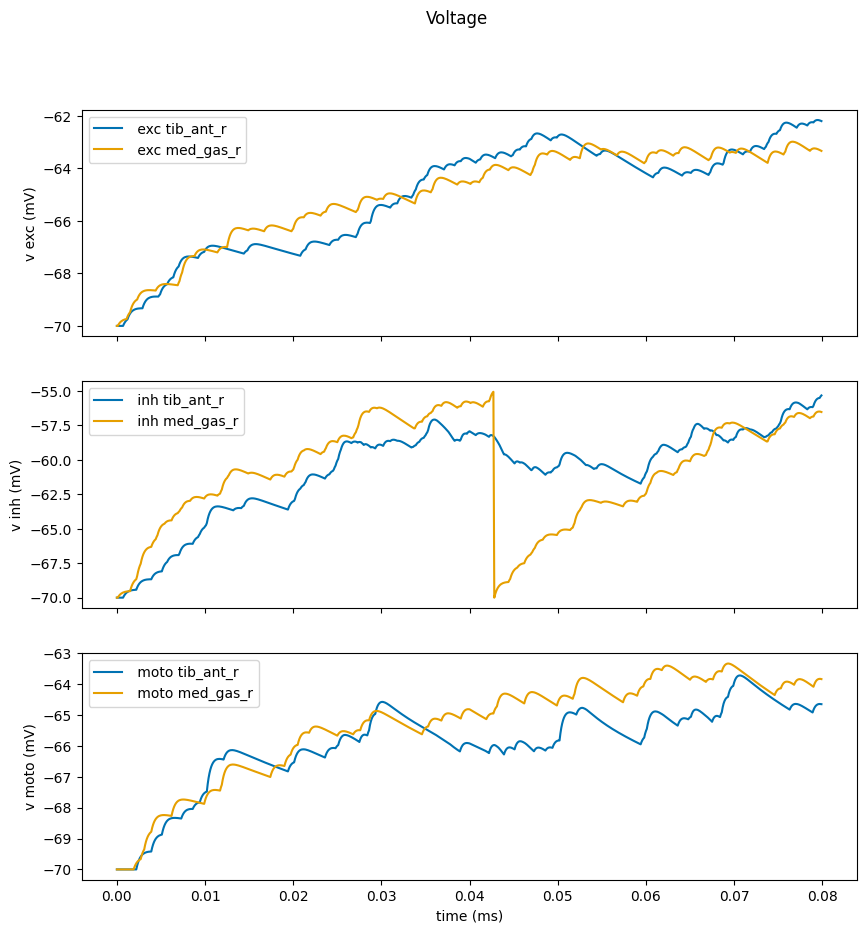

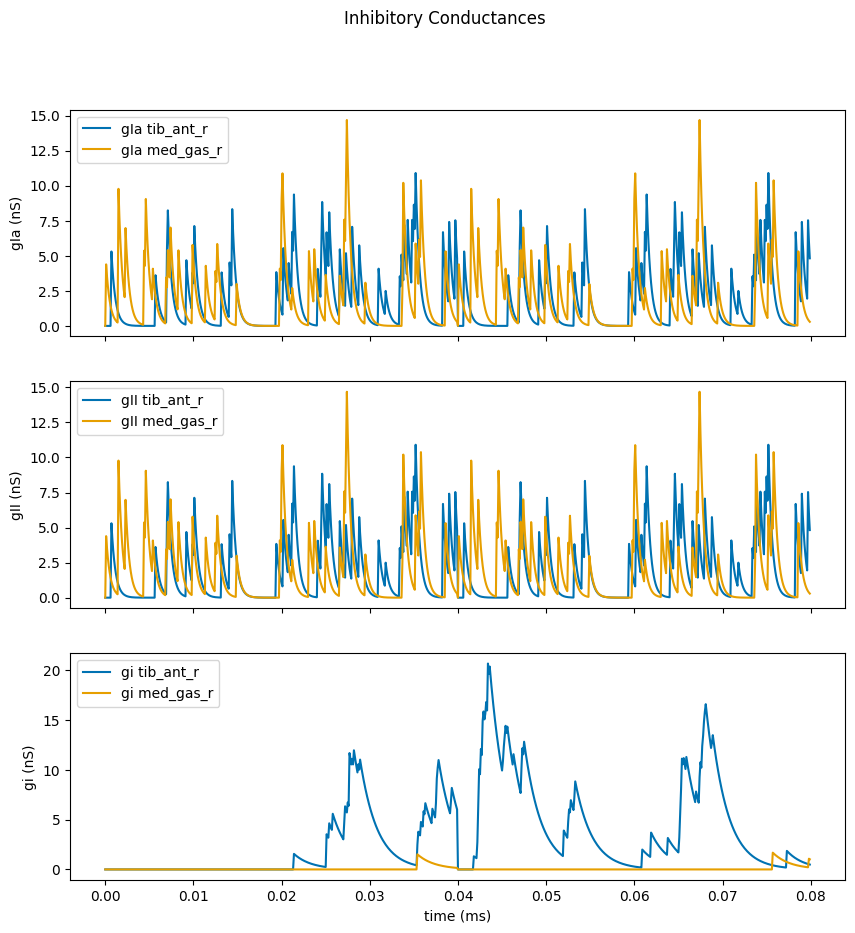

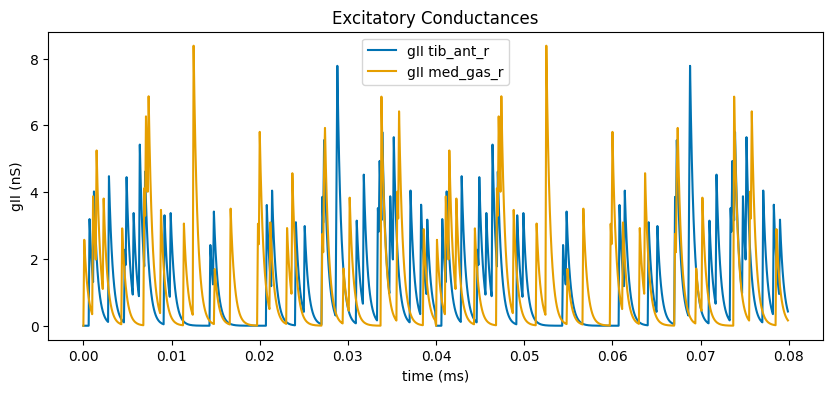

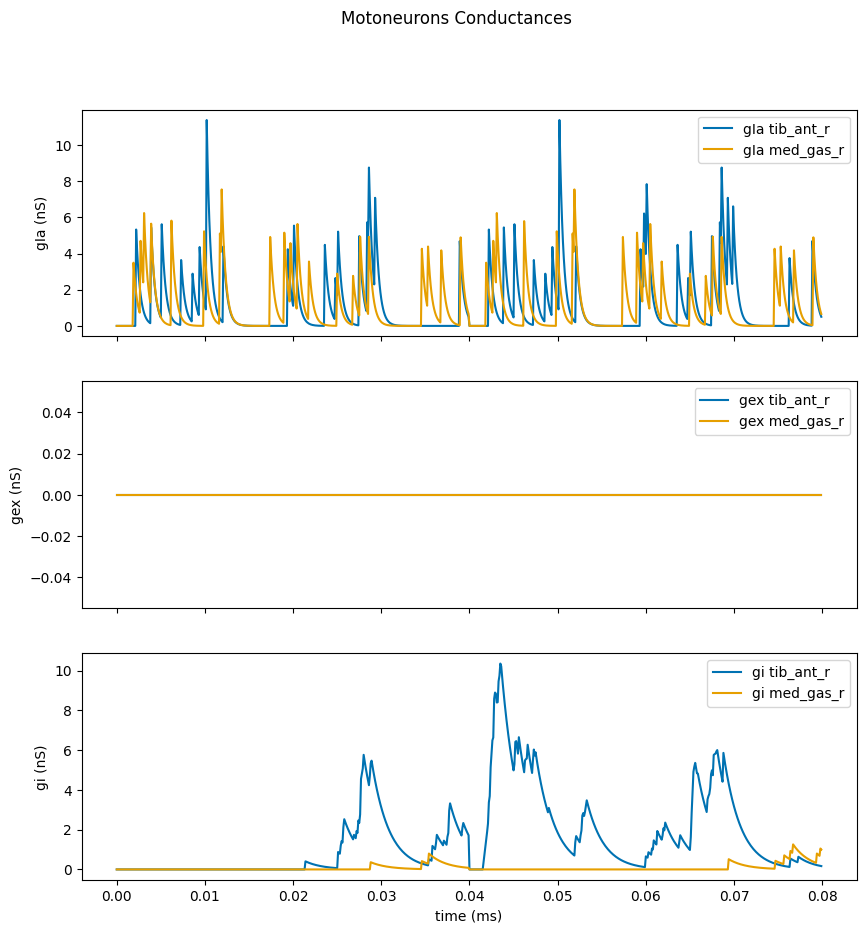

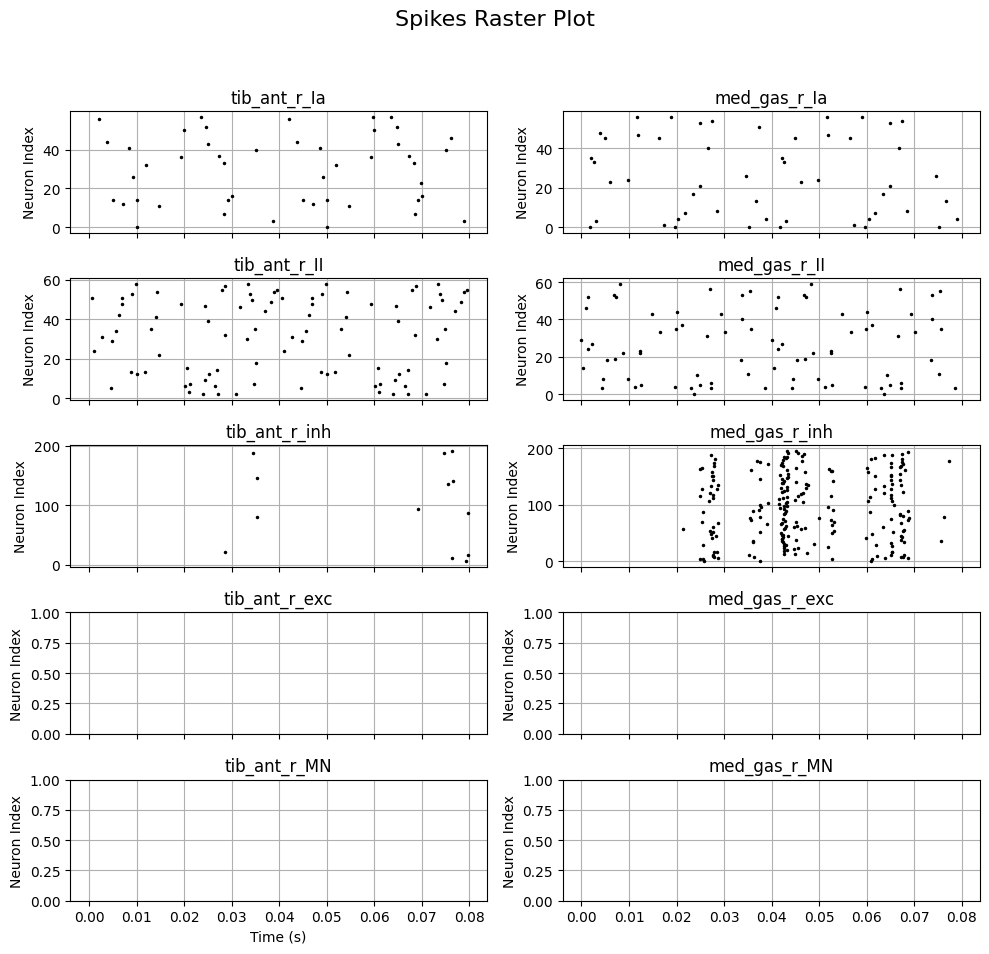

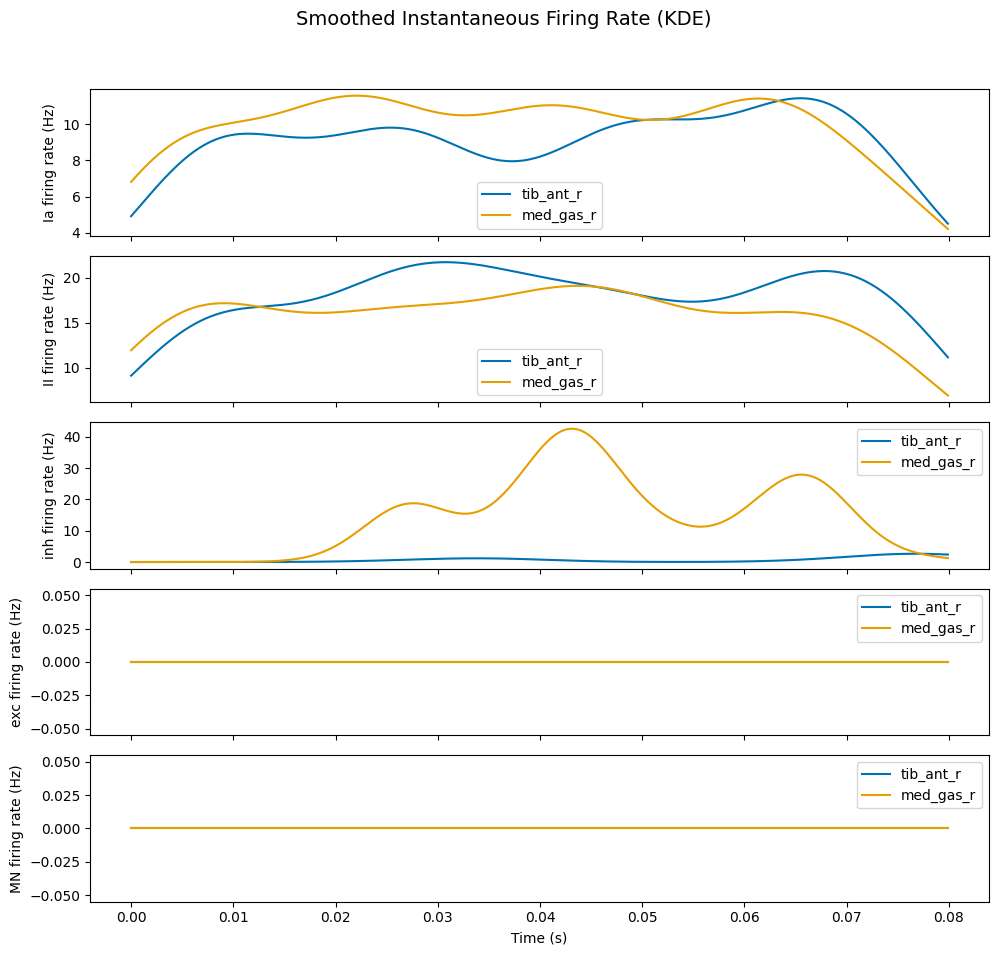

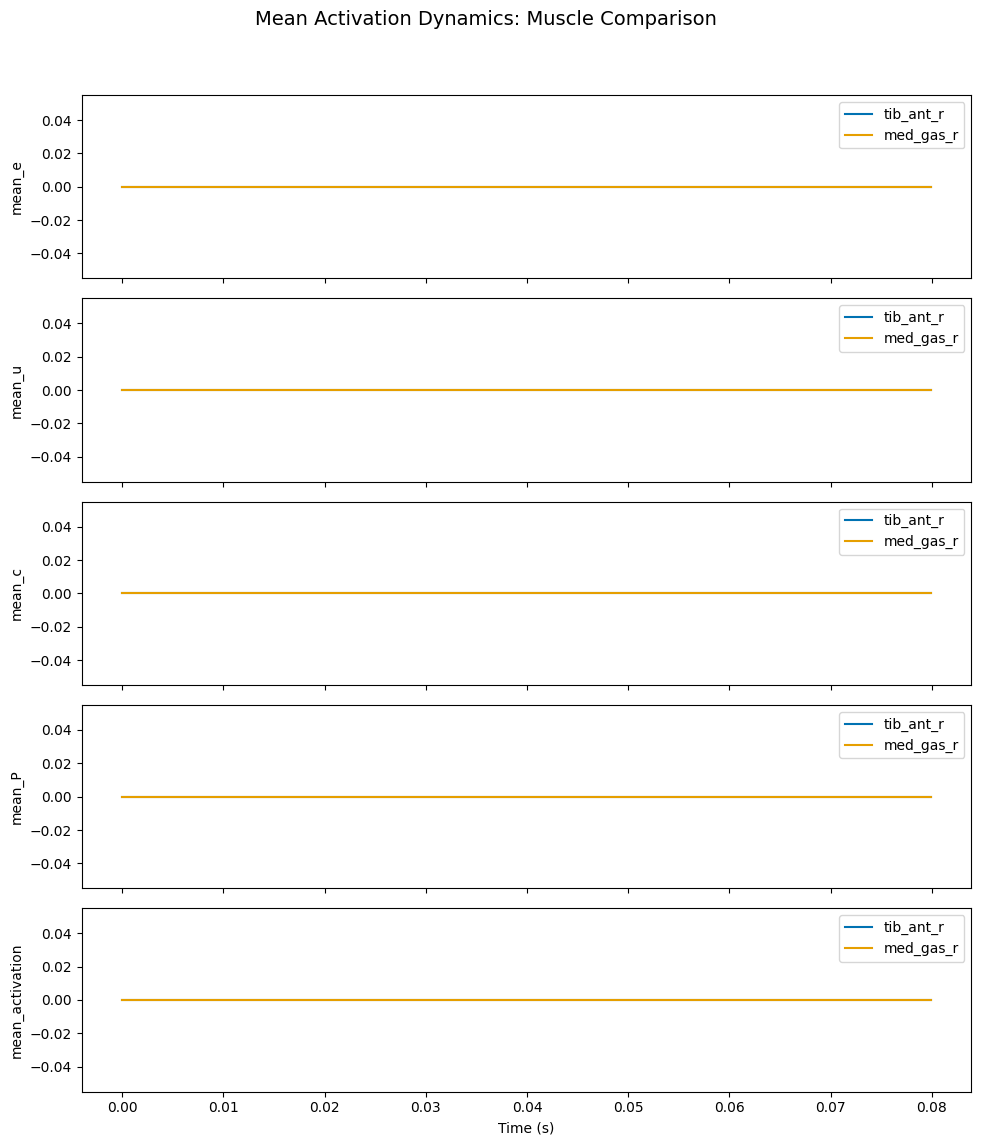

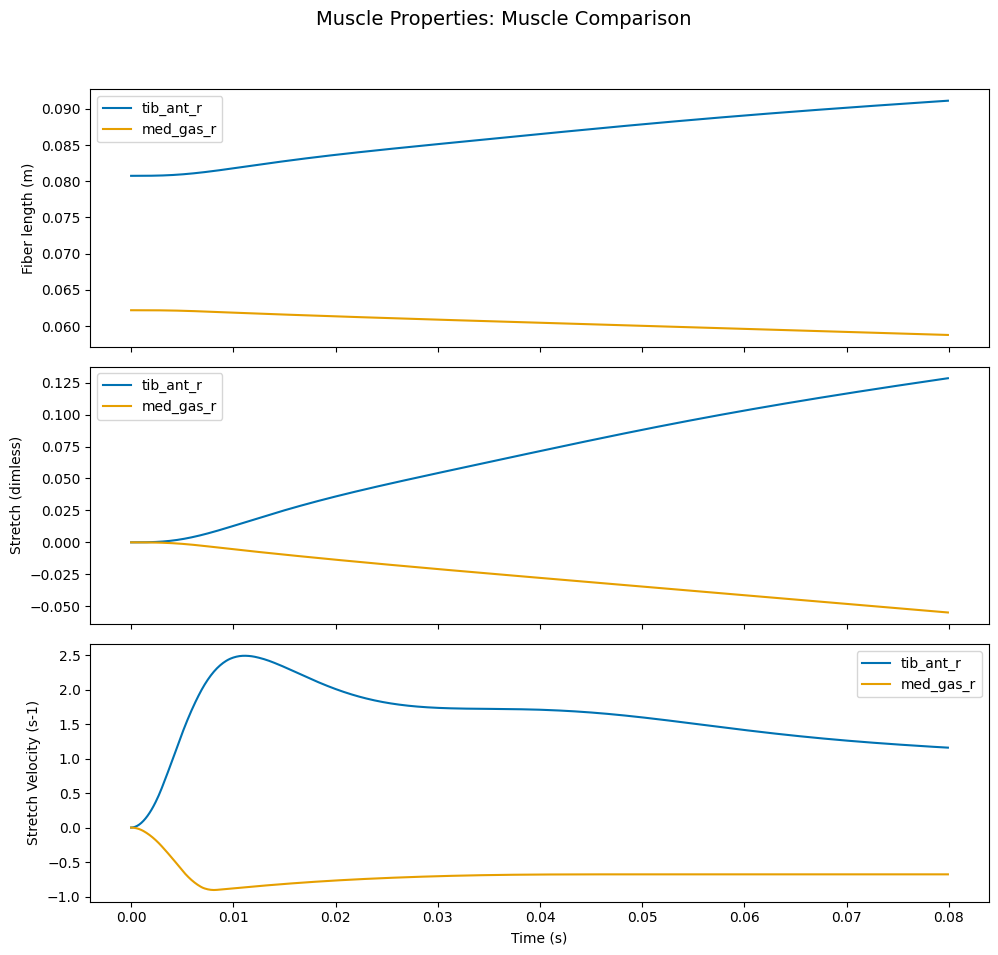

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
Setting muscles to resting state
results/All_opensim_Ia_60_II_60_Moto_0_Freq_0. Hz.sto file is saved




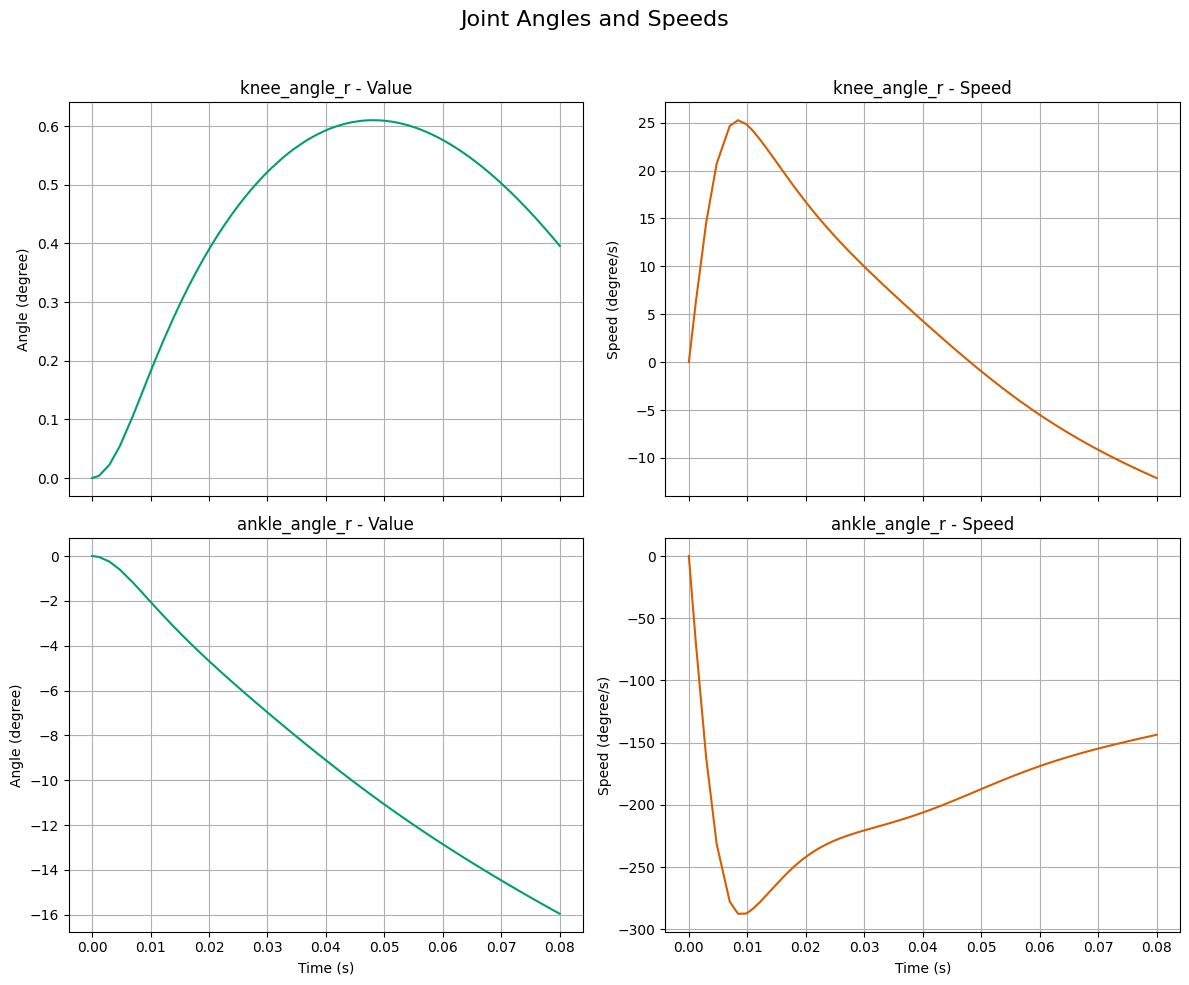

In [27]:
NEURON_COUNTS = {
      "Ia": 60,       # Type Ia afferent neurons
      "II": 60,       # Type II afferent neurons
      "inh": 196,     # Inhibitory interneurons
      "exc": 196,     # Excitatory interneurons
      "motor": 169    # Motor neurons
}

EES_PARAMS = {
    'ees_freq': 0 * hertz,      # Frequency of epidural electrical stimulation
    'Ia_recruited': 60,     # Number of Ia fibers recruited
    'II_recruited': 60,     # Number of II fibers recruited
    'eff_recruited': 0       # Number of efferent fibers recruited
}


equation_Ia = "10+ 0.4*stretch + 0.86*sign(velocity)*abs(velocity)**0.6"
equation_II="20 + 3.375*stretch"

BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'Eleaky':-70*mV,
    'gL':10*nS,
    'Cm':0.3*nF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_e':0.5*ms,
    'tau_1':2*ms,
    'tau_2':4.5*ms,
    'threshold_v':-55*mV
}
CONNECTIONS = {
        ("Ia_flexor", "moto_flexor"): {"w":2*2.1*nS, "p": 0.7},
        ("Ia_flexor", "inh_flexor"): {"w":2*3.64*nS, "p": 0.7},
        ("Ia_extensor", "moto_extensor"): { "w": 2*2.1*nS, "p": 0.7},
        ("Ia_extensor", "inh_extensor"): {"w":2*3.64*nS, "p": 0.7},

        ("II_flexor", "exc_flexor"): {"w":2*1.65*nS, "p": 0.7},
        ("II_flexor", "inh_flexor"): {"w":2*2.19*nS, "p": 0.7},
        ("II_extensor", "exc_extensor"): {"w":2*1.65*nS, "p": 0.7},
        ("II_extensor", "inh_extensor"): {"w":2* 2.19*nS, "p": 0.7},

        ("exc_flexor", "moto_flexor"): {"w":2*0.7*nS, "p": 0.5},
        ("exc_extensor", "moto_extensor"): {"w":2*0.7*nS, "p": 0.5},

        ("inh_flexor", "moto_extensor"): {"w":2*0.2*nS,  "p": 0.7},
        ("inh_extensor", "moto_flexor"): {"w":2*0.2*nS, "p": 0.7},
        ("inh_flexor", "inh_extensor"): {"w":2*0.75*nS, "p": 0.4},
        ("inh_extensor", "inh_flexor"): {"w":2* 0.75*nS, "p": 0.4}
    }


MUSCLES_STR= "tib_ant_r,med_gas_r"  # Comma-separated muscle names
spikes, muscles, joints=spikes,others_data, joints=closed_loop(2,EES_PARAMS,NEURON_COUNTS ,CONNECTIONS,equation_Ia, equation_II, BIOPHYSICAL_PARAMS, MUSCLES_STR, plots=True)

EES frequency: 10.0 Hz
Start Simulation :
EES frequency : 10. Hz
Number Ia fibers recruited by EES: 60 / 60
Number II fibers recruited by EES : 60 / 60
Number Efferent fibers recruited by EES : 0 / 169
--- Iteration 1 of 10 ---
Number of flexor recruited motoneuron: 0/169
Number of extensor recruited motoneuron: 0/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 2 of 10 ---
Number of flexor recruited motoneuron: 0/169
Number of extensor recruited motoneuron: 0/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 3 of 10 ---
Number of flexor recruited motoneuron: 0/169
Number of extensor recruited motoneuron: 0/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

KeyboardInterrupt: 

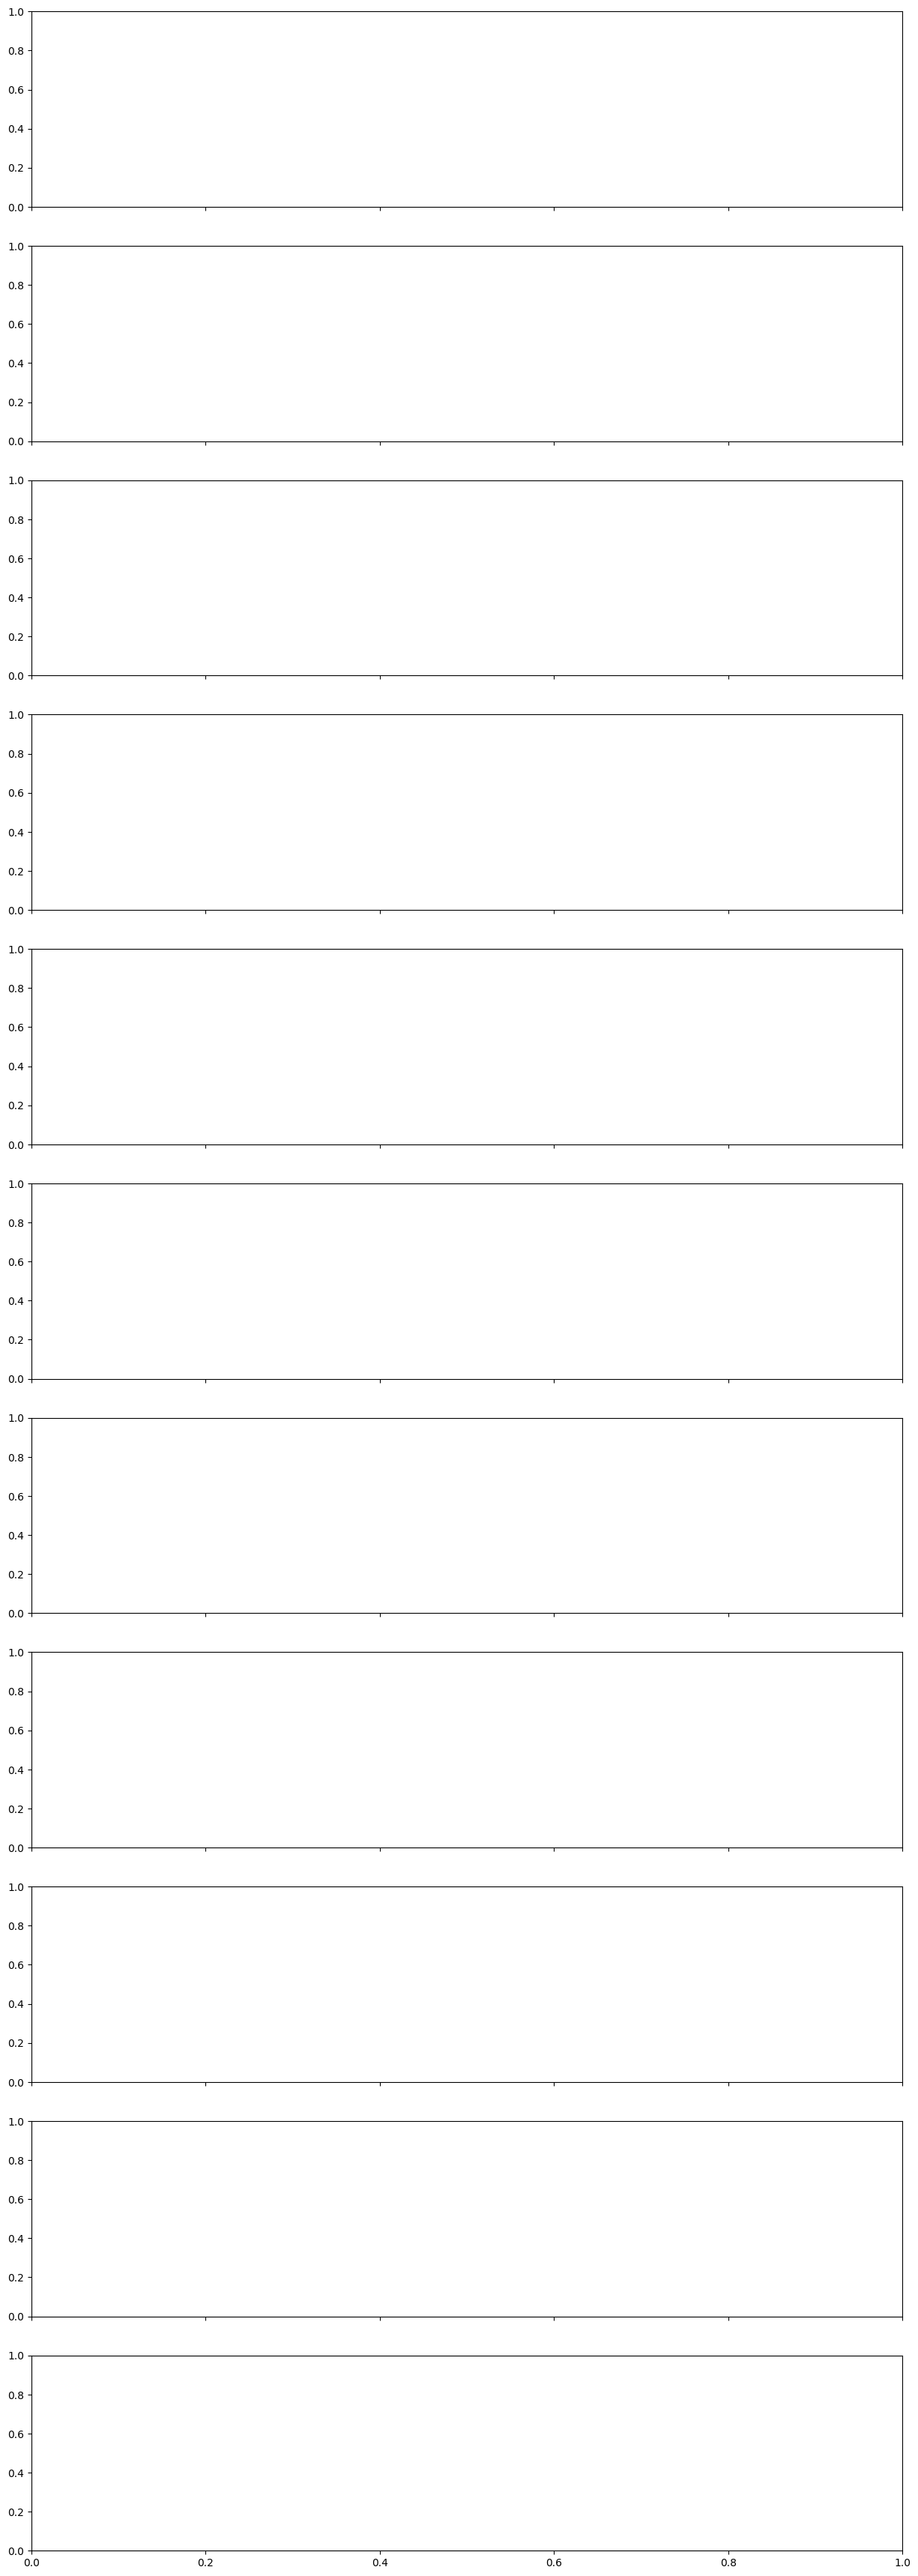

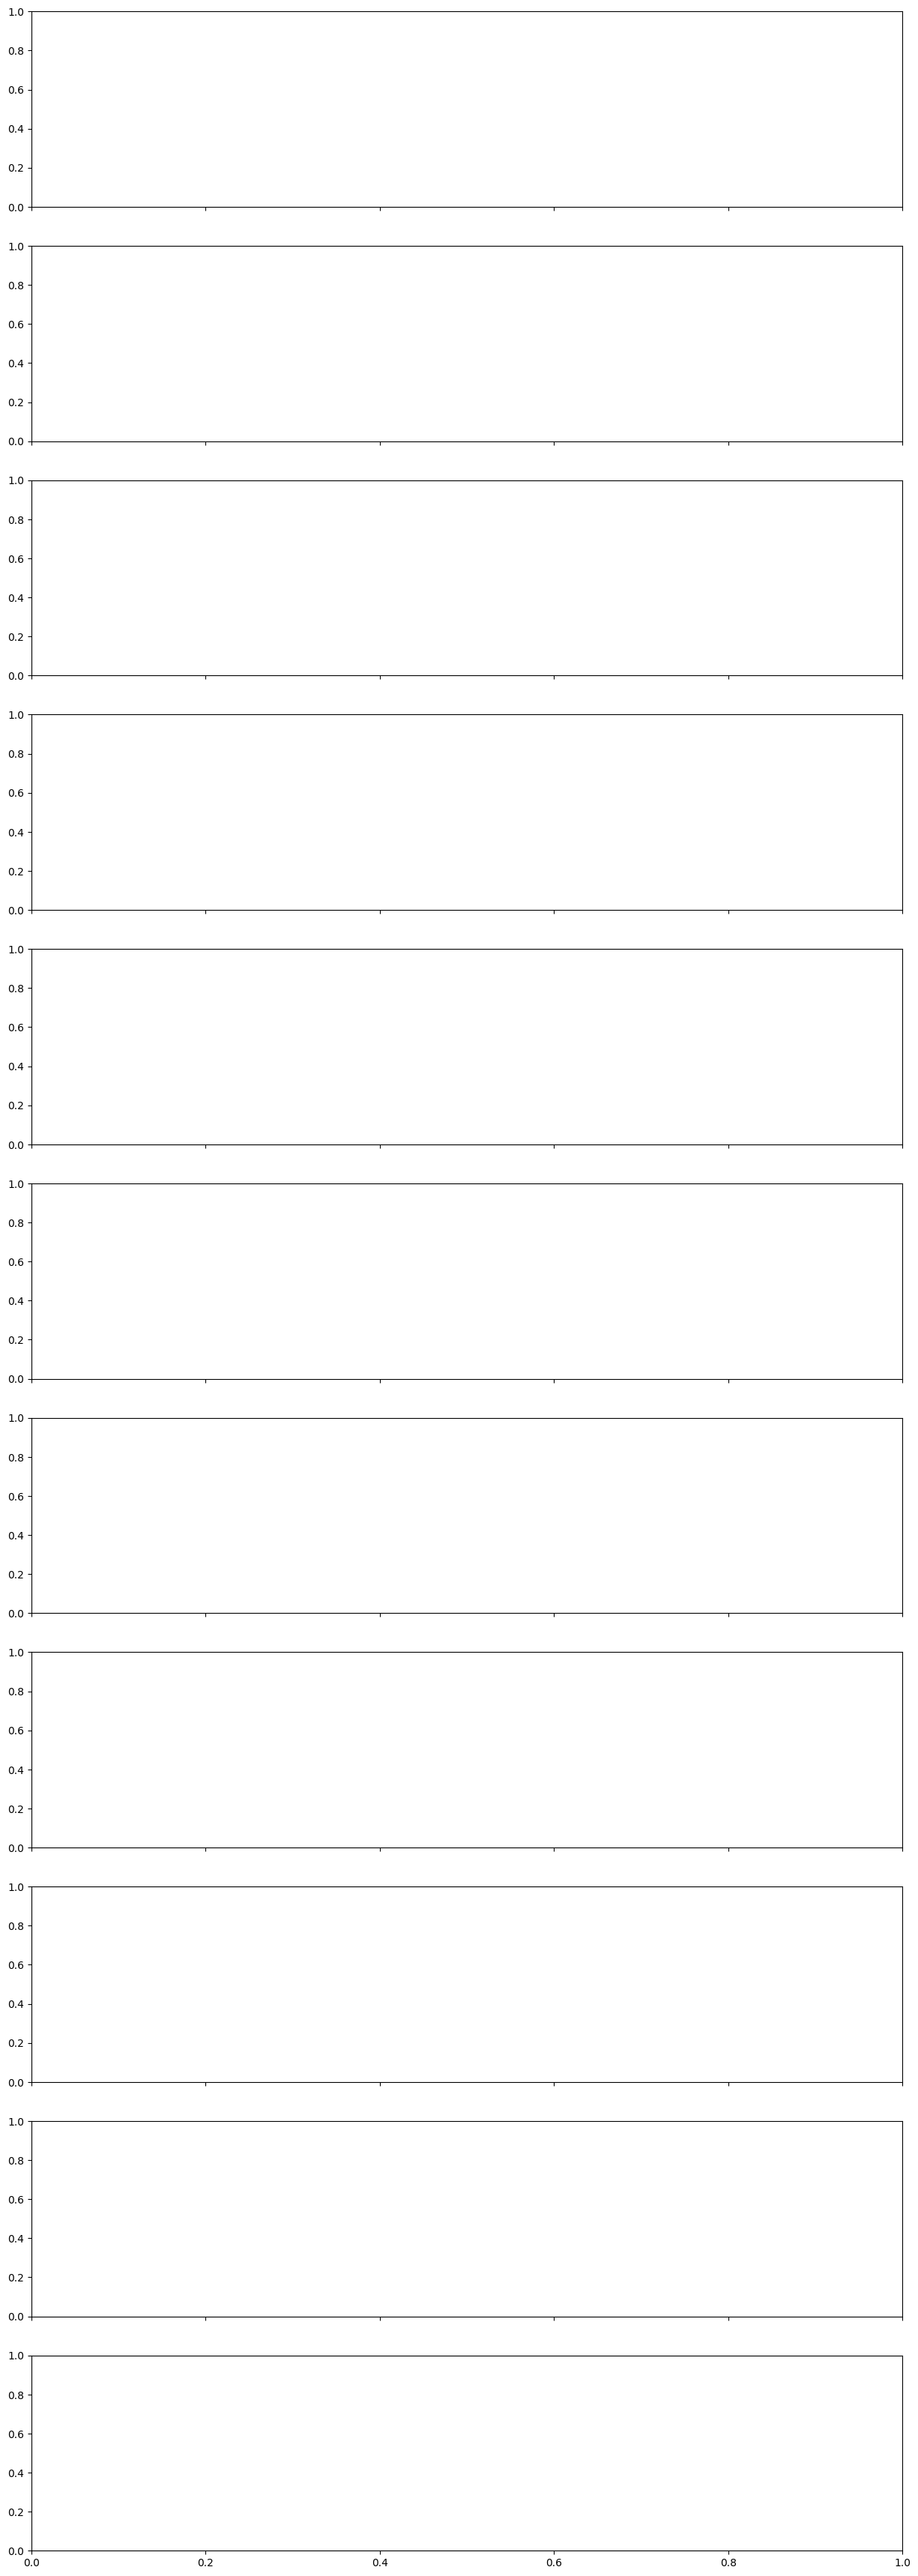

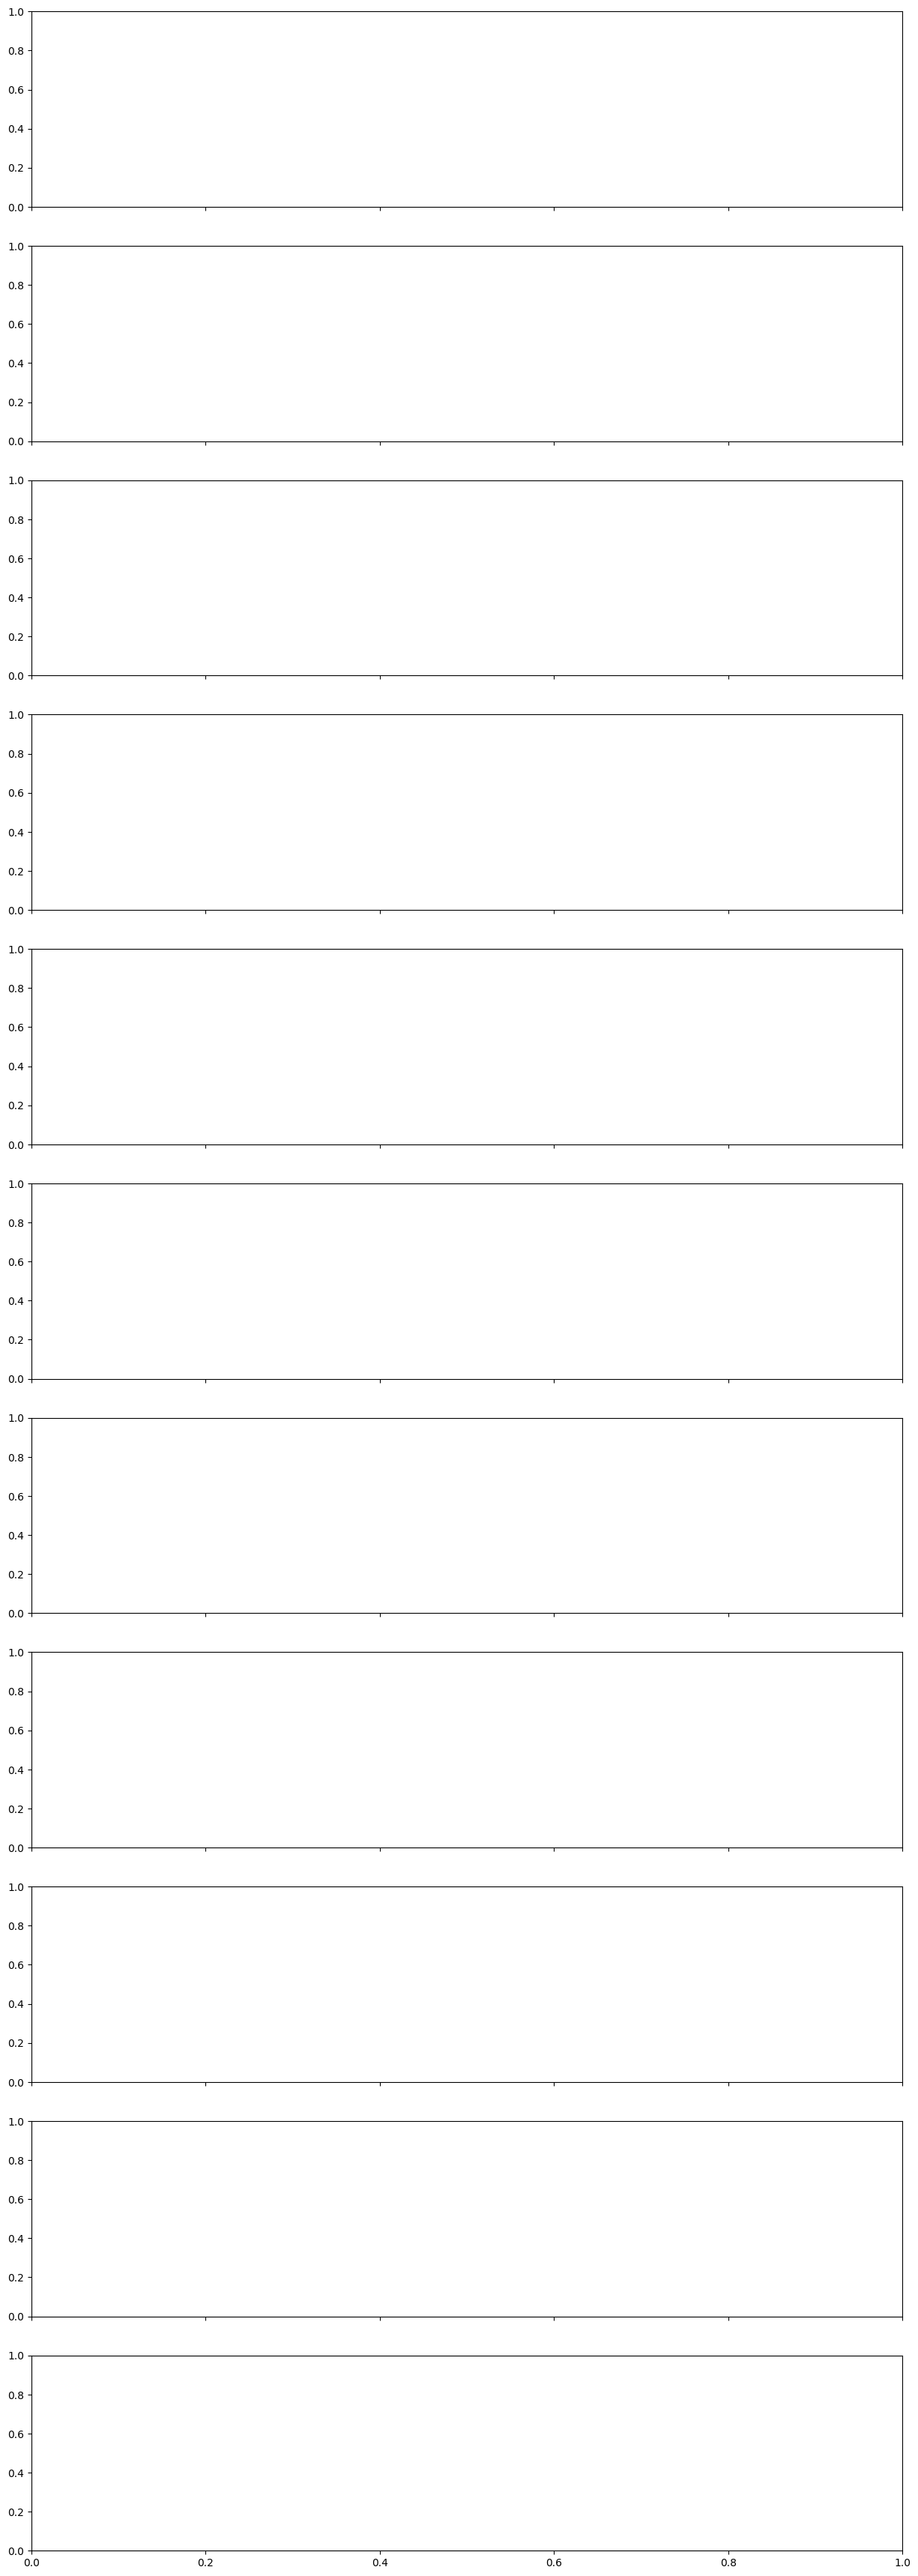

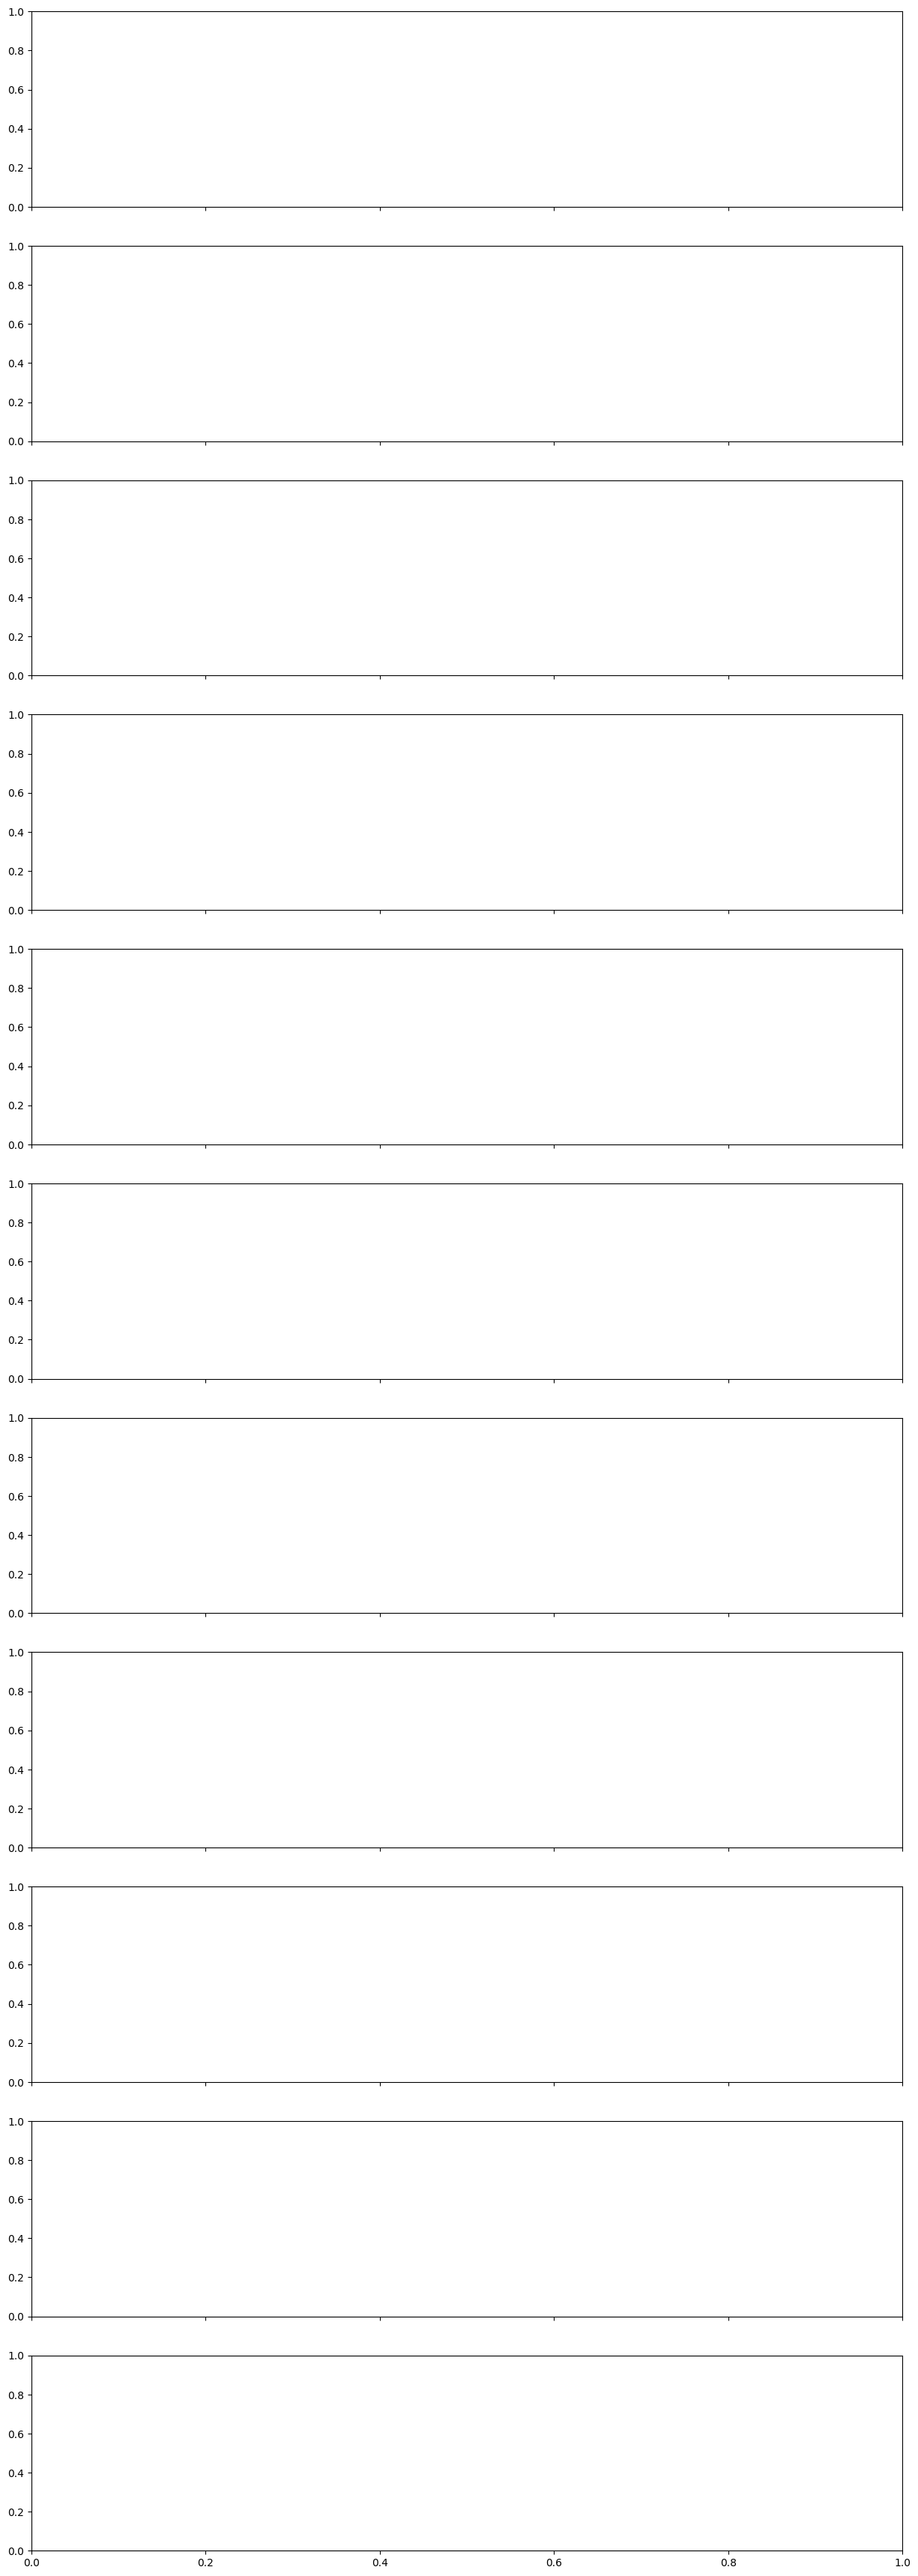

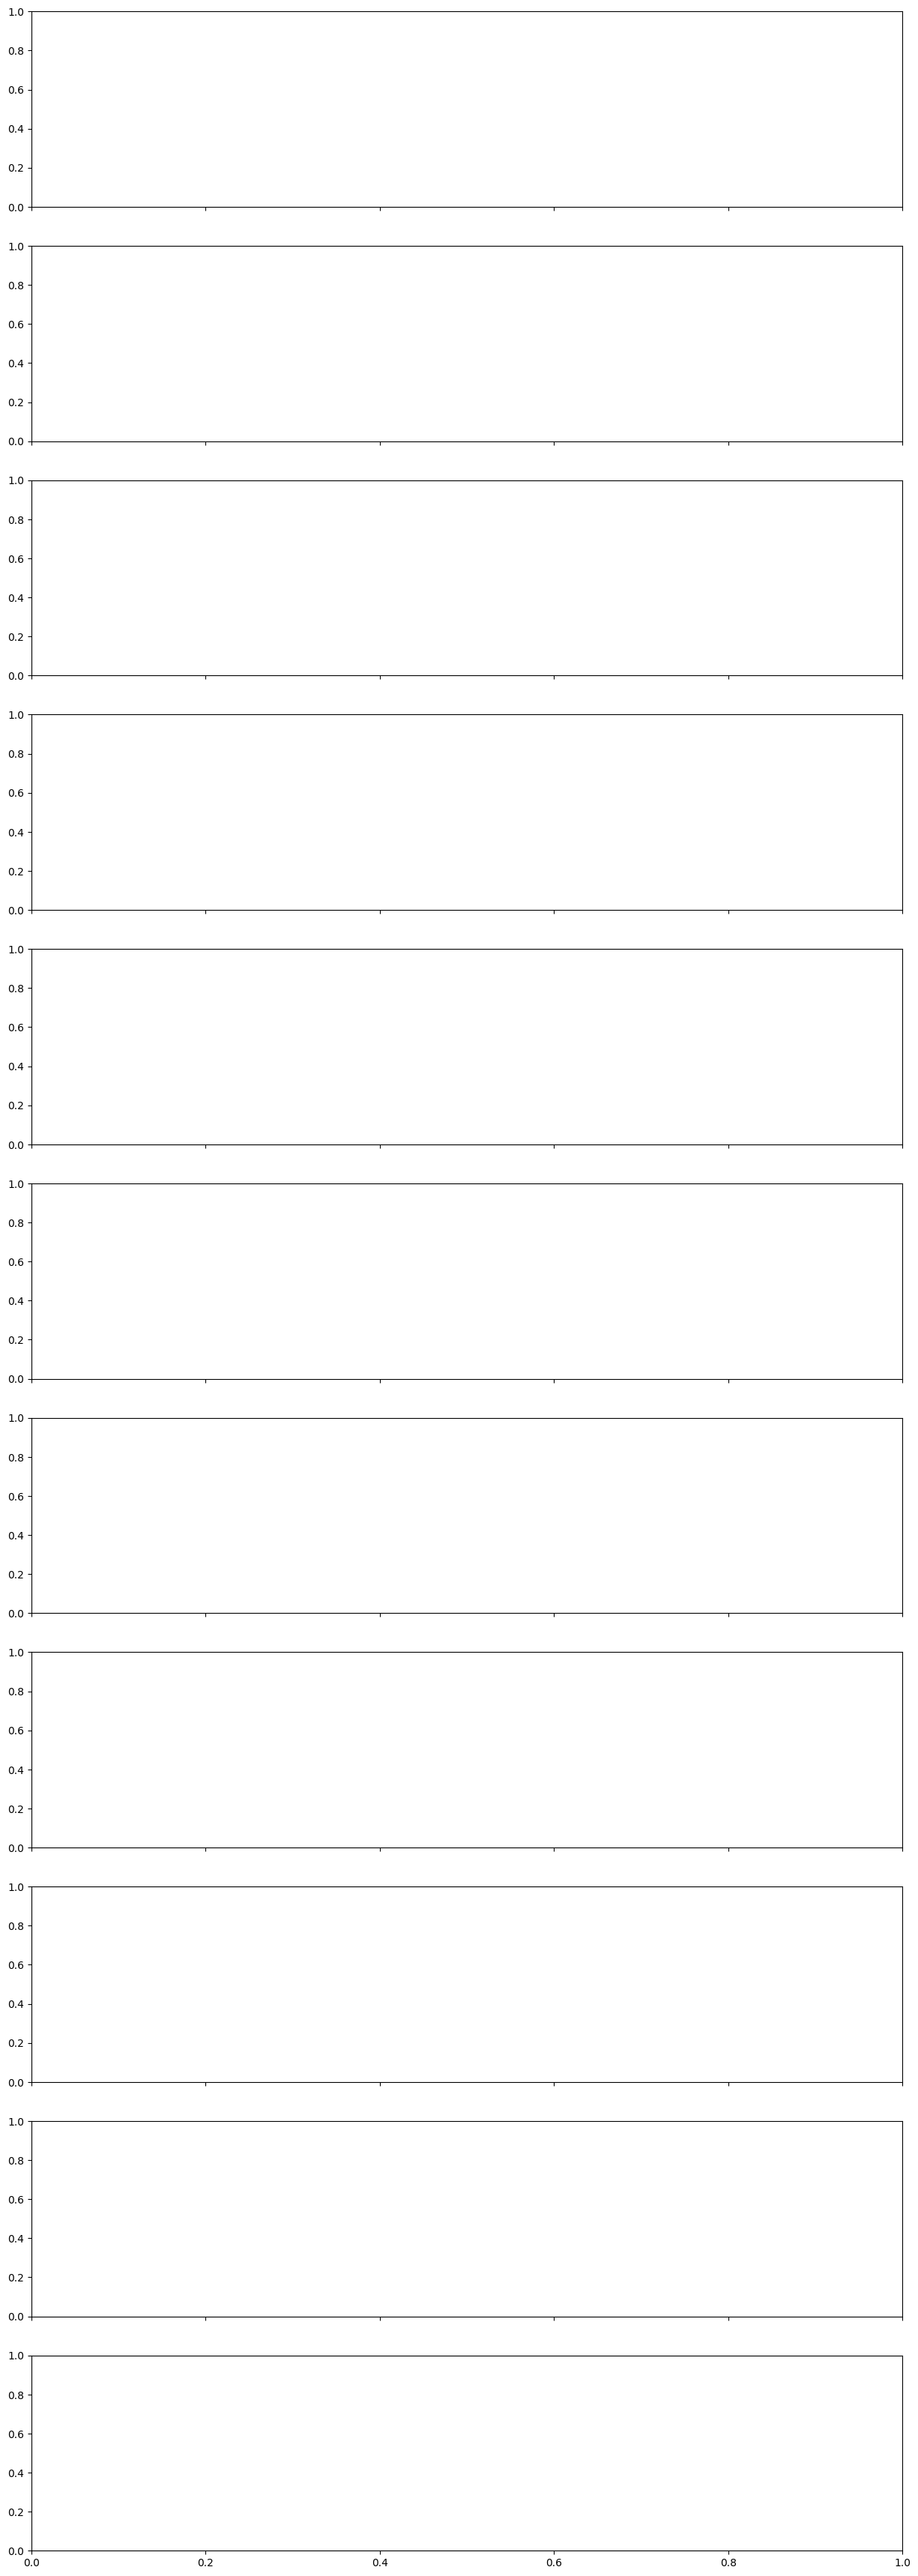

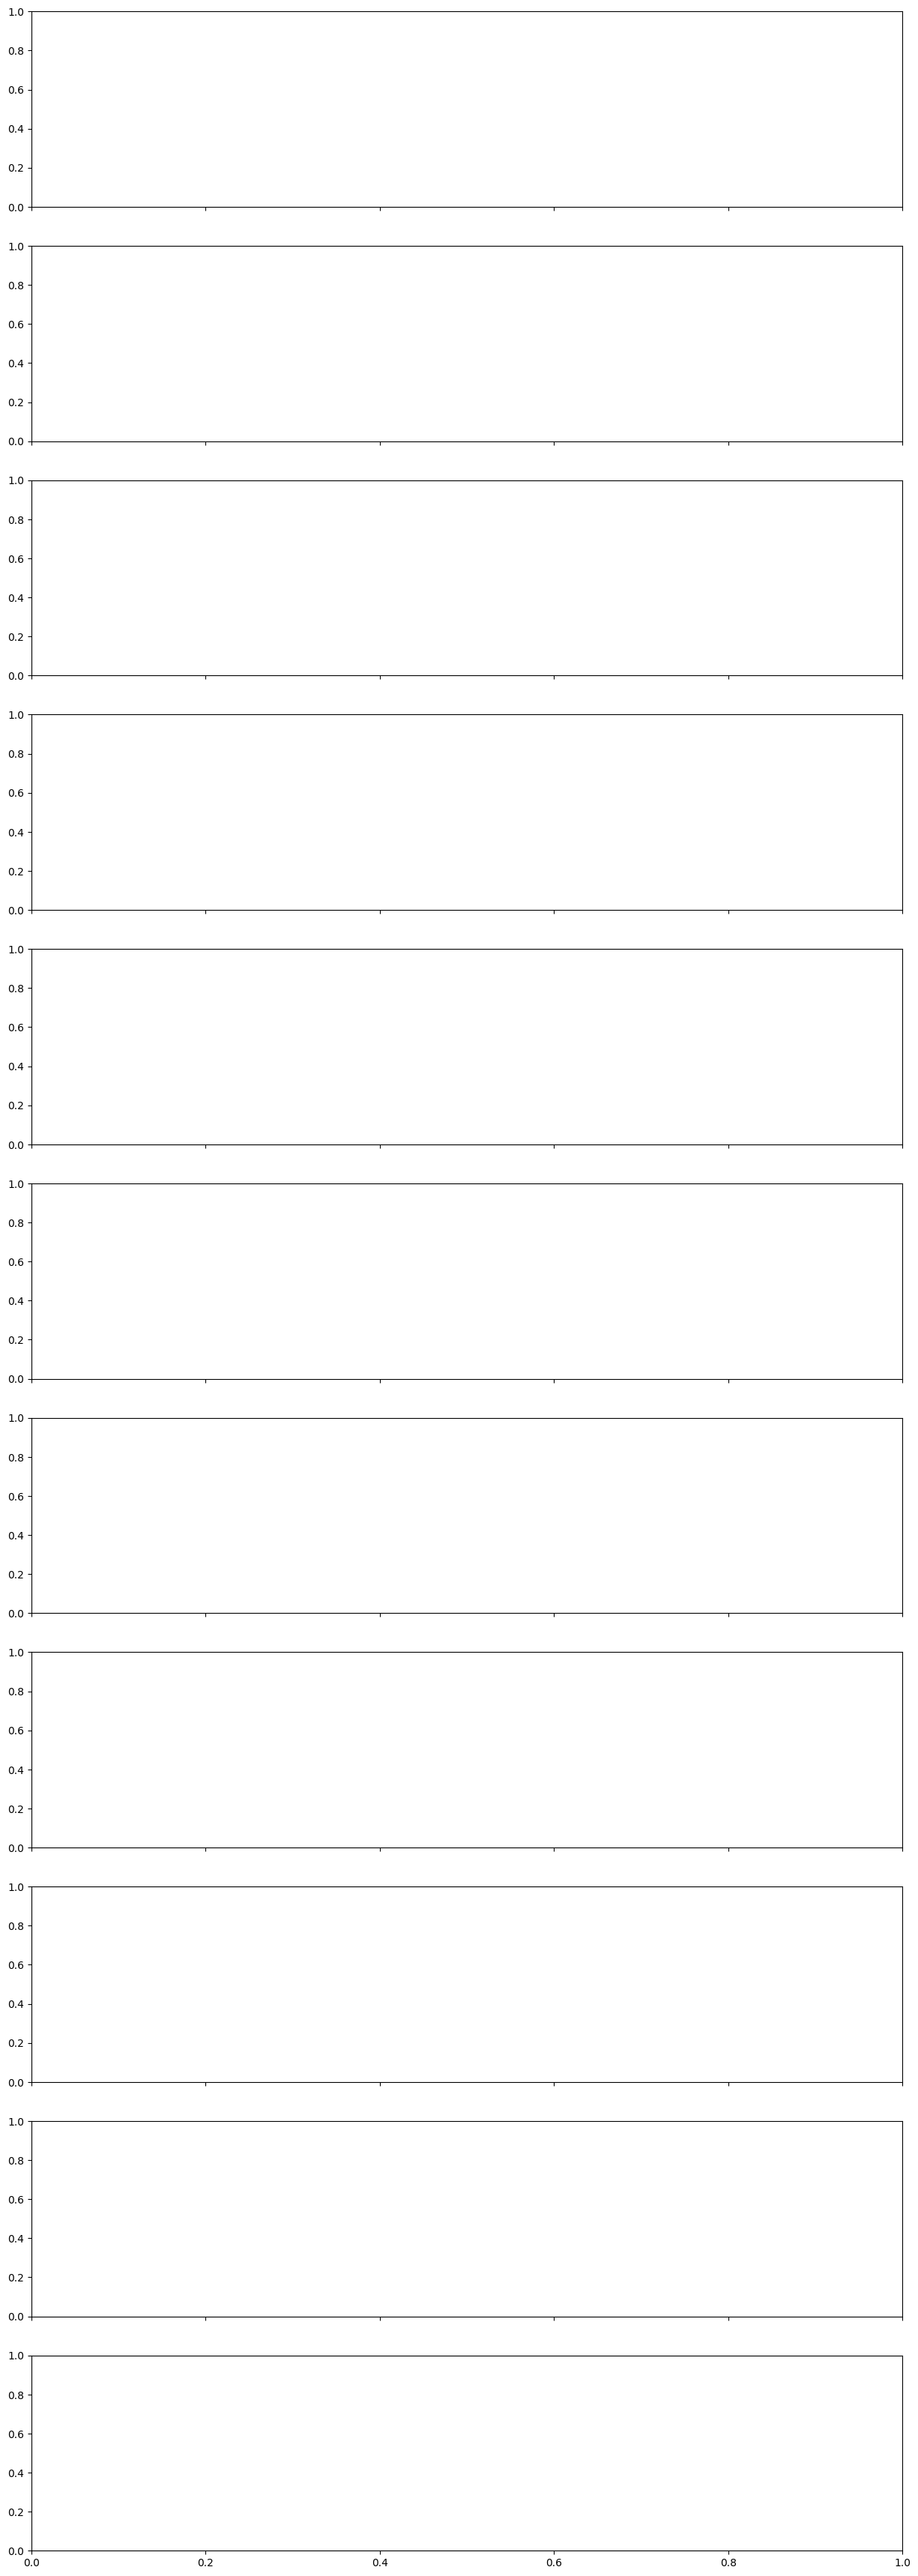

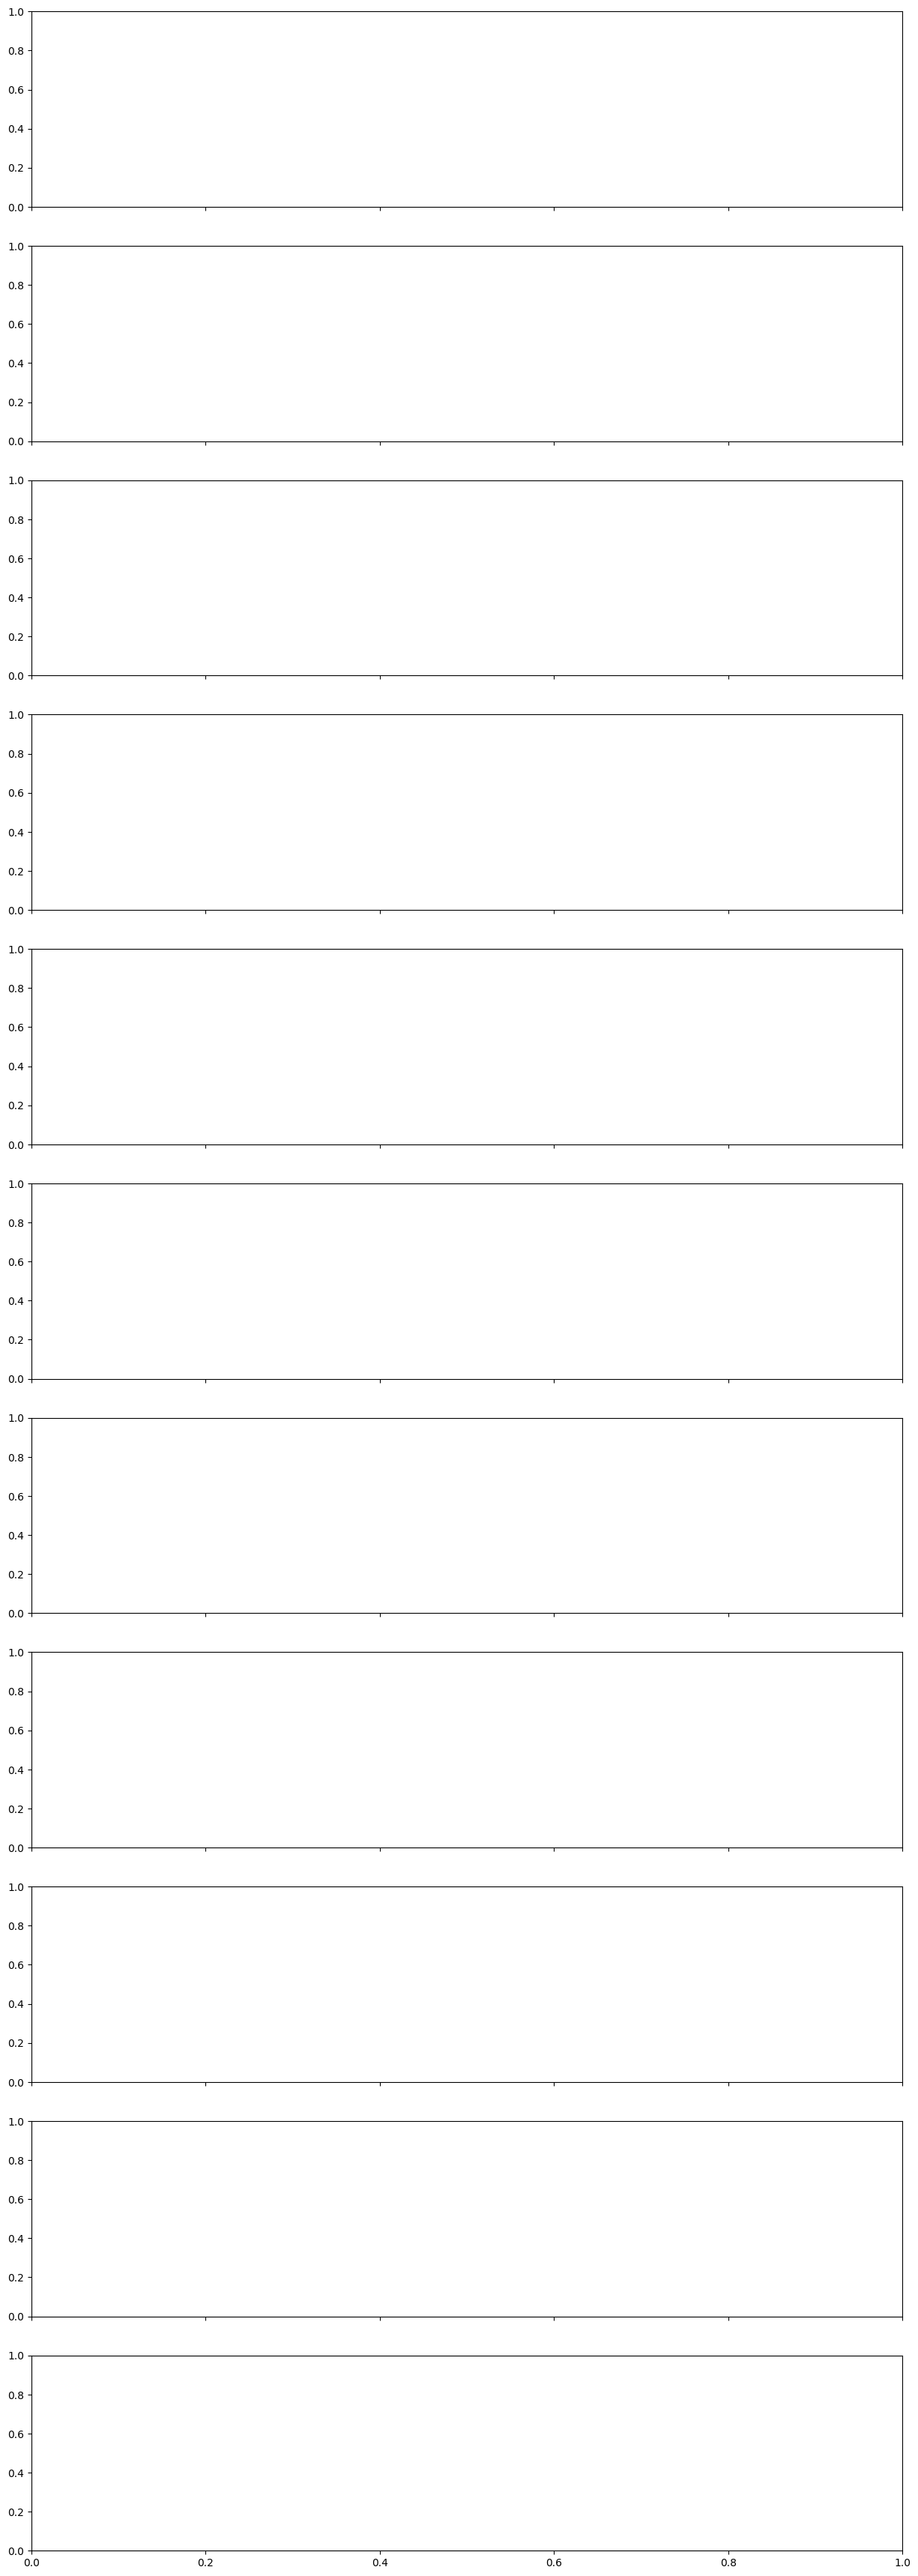

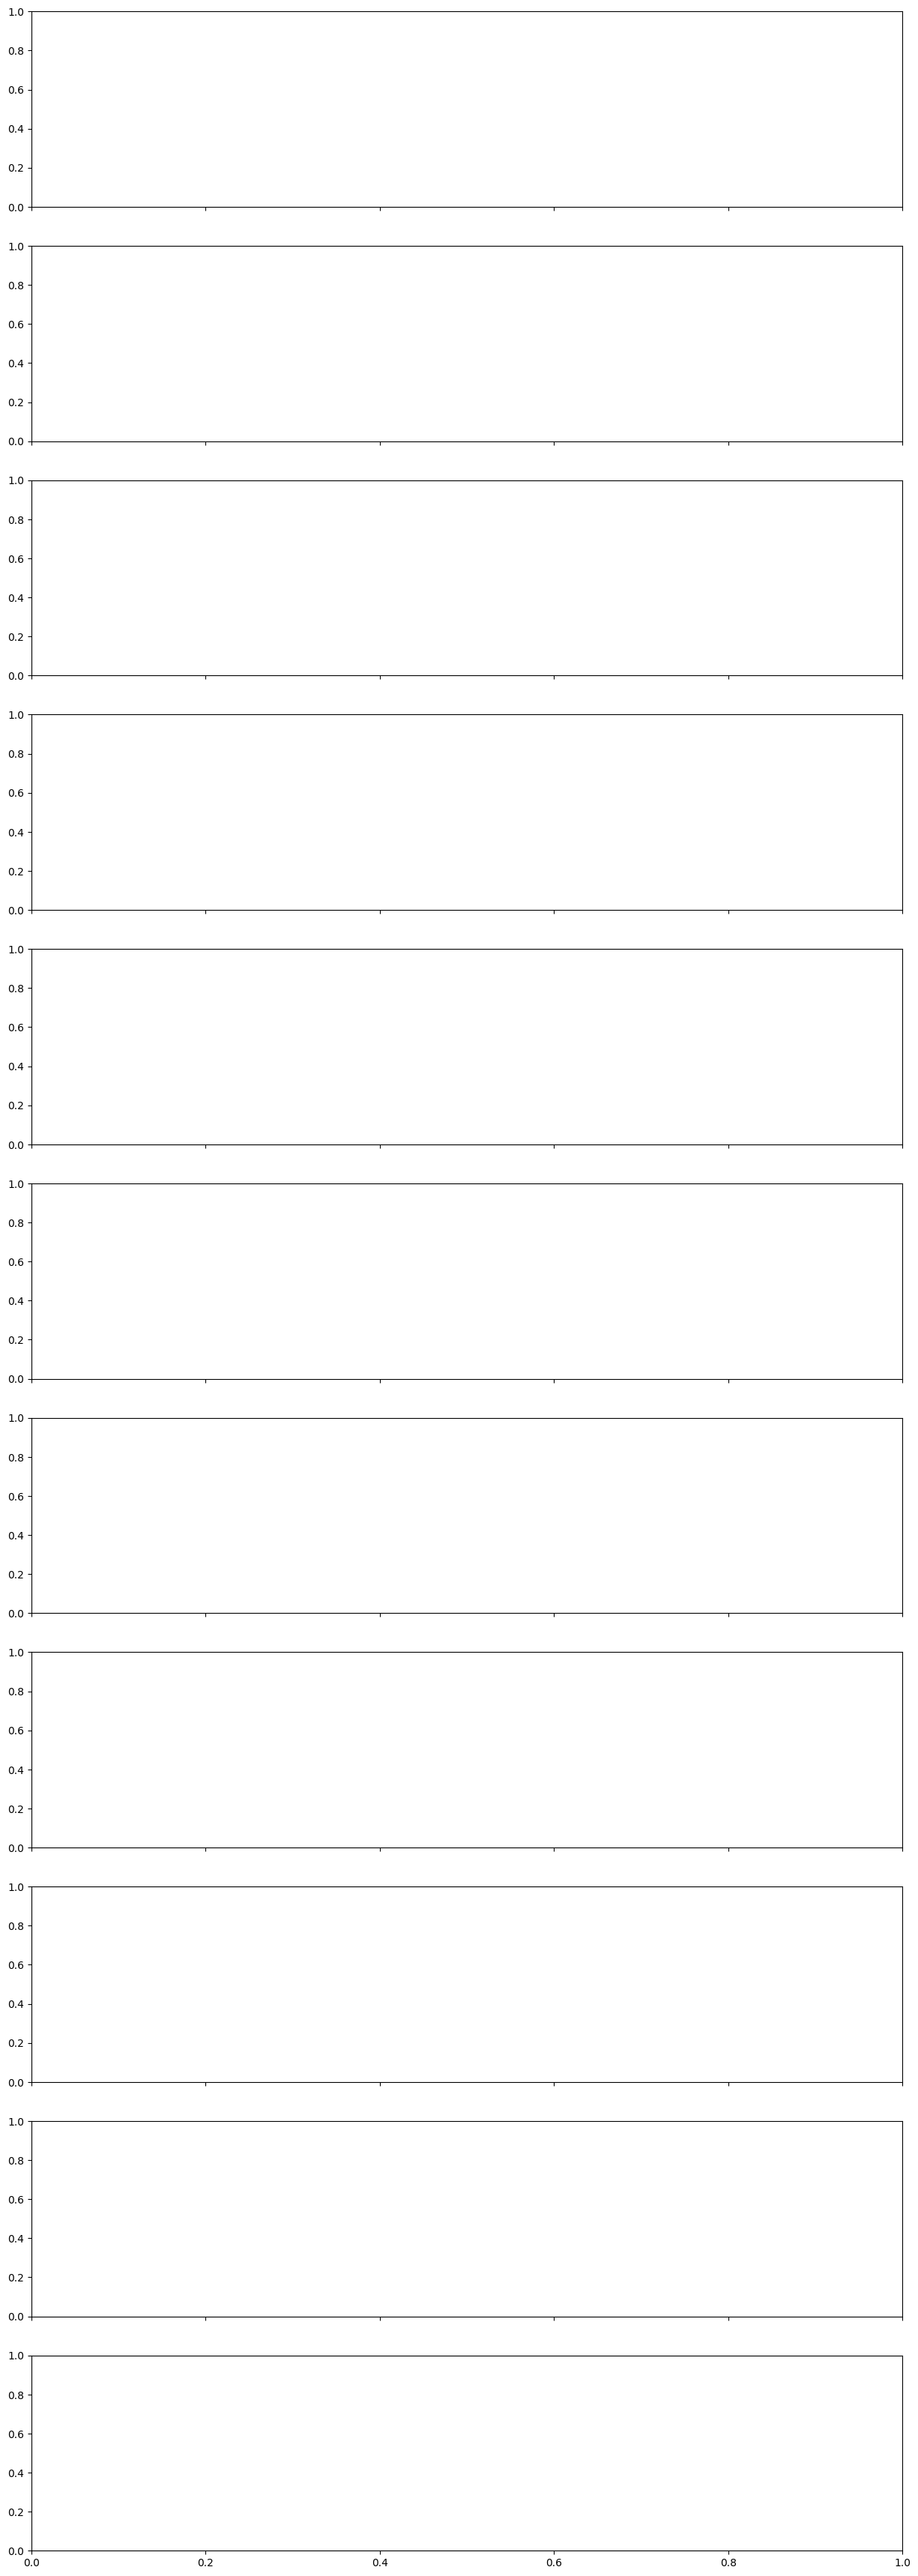

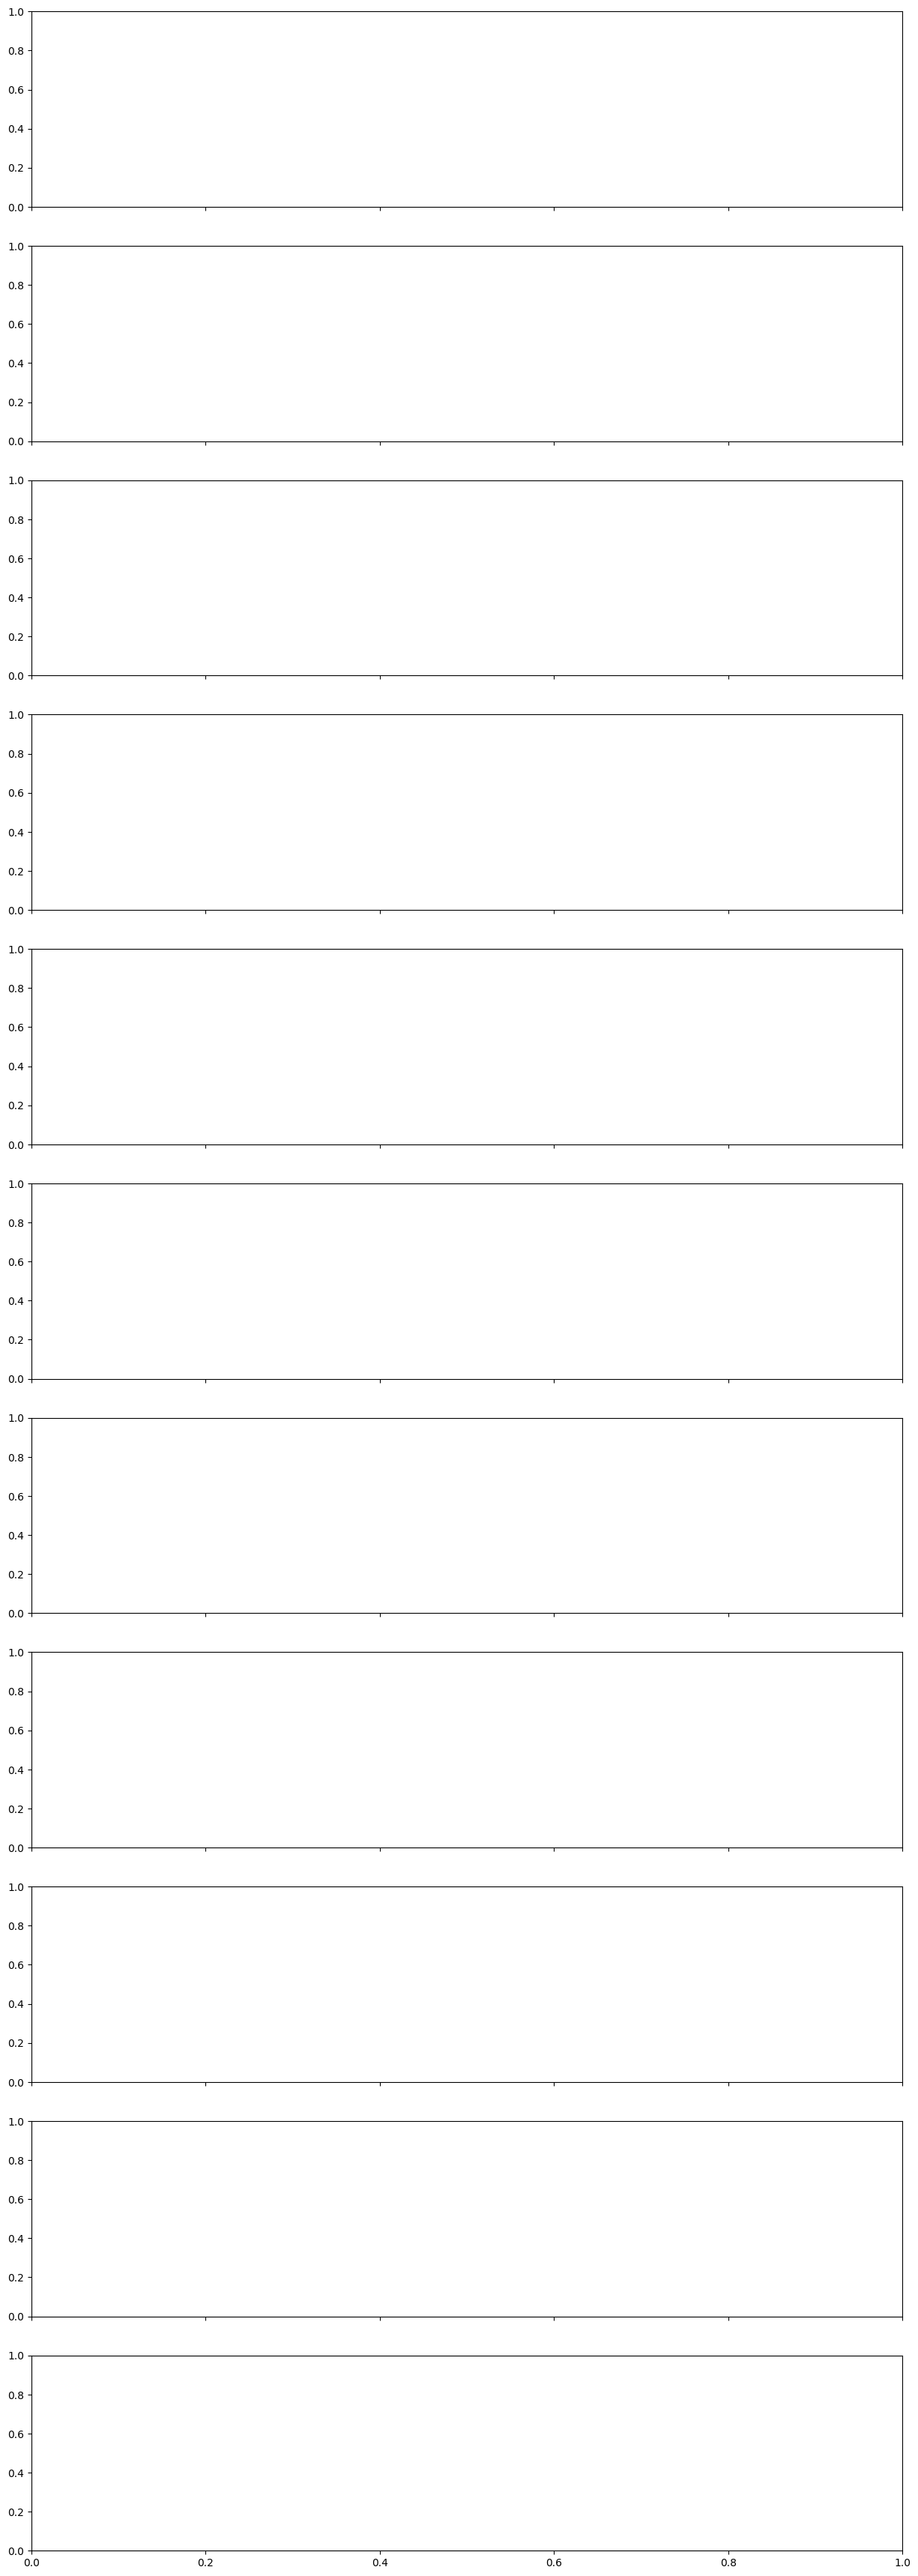

In [16]:
# Neural population parameters
NEURON_COUNTS = {
      "Ia": 60,       # Type Ia afferent neurons
      "II": 60,       # Type II afferent neurons
      "inh": 196,     # Inhibitory interneurons
      "exc": 196,     # Excitatory interneurons
      "motor": 169    # Motor neurons
}

EES_PARAMS = {
    'ees_freq': 0 * hertz,      # Frequency of epidural electrical stimulation
    'Ia_recruited': 60,     # Number of Ia fibers recruited
    'II_recruited': 60,     # Number of II fibers recruited
    'eff_recruited': 0       # Number of efferent fibers recruited
}


equation_Ia = "10+ 0.4*stretch + 0.86*sign(velocity)*abs(velocity)**0.6"
equation_II="20 + 3.375*stretch"

BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'Eleaky':-70*mV,
    'gL':10*nS,
    'Cm':0.3*nF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_e':0.5*ms,
    'tau_1':2*ms,
    'tau_2':4.5*ms,
    'threshold_v':-55*mV
}
CONNECTIONS = {
        ("Ia_flexor", "moto_flexor"): {"w":2*2.1*nS, "p": 0.7},
        ("Ia_flexor", "inh_flexor"): {"w":2*3.64*nS, "p": 0.7},
        ("Ia_extensor", "moto_extensor"): { "w": 2*2.1*nS, "p": 0.7},
        ("Ia_extensor", "inh_extensor"): {"w":2*3.64*nS, "p": 0.7},

        ("II_flexor", "exc_flexor"): {"w":2*1.65*nS, "p": 0.7},
        ("II_flexor", "inh_flexor"): {"w":2*2.19*nS, "p": 0.7},
        ("II_extensor", "exc_extensor"): {"w":2*1.65*nS, "p": 0.7},
        ("II_extensor", "inh_extensor"): {"w":2* 2.19*nS, "p": 0.7},

        ("exc_flexor", "moto_flexor"): {"w":2*0.7*nS, "p": 0.5},
        ("exc_extensor", "moto_extensor"): {"w":2*0.7*nS, "p": 0.5},

        ("inh_flexor", "moto_extensor"): {"w":2*0.2*nS,  "p": 0.7},
        ("inh_extensor", "moto_flexor"): {"w":2*0.2*nS, "p": 0.7},
        ("inh_flexor", "inh_extensor"): {"w":2*0.75*nS, "p": 0.4},
        ("inh_extensor", "inh_flexor"): {"w":2* 0.75*nS, "p": 0.4}
    }


MUSCLES_STR= "tib_ant_r,med_gas_r"  # Comma-separated muscle names
muscles_names=MUSCLES_STR.split(',')

EES_freq= np.linspace(10, 100, 11)
time_series_to_plot = ['Ia_FR', 'II_FR', 'IPSP_inh','IPSP_MN','recruited_MN','MN_FR','mean_activity','stretch', 'joints']
other_to_plot= ['phase_activity','co_activation','total_time_activation']

# Create one figure per variable with subplots for each frequency
figs = {}
axs_dict = {}
activities=[{} for _ in range(len(muscles_names))]
n_rows = len(EES_freq)

for var in time_series_to_plot:
    fig, axs = plt.subplots(n_rows, 1, figsize=(15, 4 * n_rows), sharex=True)
    axs = axs.flatten()
    figs[var] = fig
    axs_dict[var] = axs


for i,freq in enumerate(EES_freq):
    EES_PARAMS['ees_freq'] = freq * hertz
    print(f"EES frequency: {freq} Hz")
    spikes, main_data, joints=spikes,others_data, joints=closed_loop(10,EES_PARAMS,NEURON_COUNTS ,CONNECTIONS,equation_Ia, equation_II, BIOPHYSICAL_PARAMS, MUSCLES_STR, plot=True)

    for muscle_name in muscles_names:
        t=muscles[muscle_name]['Time']
        activities[i]=main_data[muscle_name]['mean_activation']
        for var in time_series_to_plot.remove('joints'):
            if var not in main_data:
                continue
            y = [var]
            ax = main_data[var][i]
            ax.plot(t, y)
            ax.set_title(f"{var}, EES freq: {freq} Hz")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel(var.replace('_', ' ').title())

    ax=axs_dict['joints'][i]
    ax.plot(joints['time'], joints['ankle_angle_r'])
    ax.set_title(f" ankle_angle, EES freq: {freq} Hz")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel('ankle_angle (degree)')

# Final layout adjustments
for var in variables_to_plot:
    axs = axs_dict[var]
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    figs[var].suptitle(f"{var.replace('_', ' ').title()} across EES frequencies", fontsize=16)
    figs[var].tight_layout()
    figs[var].subplots_adjust(top=0.9)
    plt.show()
